In [ ]:
#Analysis of long term drought dynamics in California(1895-2025) based on NOAA NCEI data(PDSI index)
#Goal:Investigate long term climate change in California using PDSI index
#Main research questions:
#-Have droughts become more severe?
#-How did the seasonality change in 130 years?

In [5]:
#import of neccesarry libraries
import pandas as pd
import requests
import re
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
#1.Data collection and preparation

#For analysis, we use automatic parsing of current files from the NOAA server. The PDSI (Palmer Drought Severity Index) measures relative dryness:
#- Negative values = drought (the lower the value, the more extreme the drought).
#- Positive values = excess moisture.

In [2]:
# Link to the current NOAA dataset (PDSI index by division)
file_url = "https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pdsidv-v1.0.0-20251204"
# Sending a request to the server
data_response = requests.get(file_url)

if data_response.status_code == 200:
    #reading data in Fixed Width Format
    #using StringIO so Pandas can read string as file
    df = pd.read_fwf(StringIO(data_response.text), header=None)
    #Assign technical headings: row ID and 12 columns for each month
    df.columns = ['RawID'] + [f'Val_{i}' for i in range(1, 13)]
    # Converting the ID to string format and fill it with zeros to 10 characters for correct parsing.
    df['RawID'] = df['RawID'].astype(str).str.zfill(10)

    # RawID structure in the NOAA database:
    # Characters 0-2: State code (04 — California)
    # Characters 2-4: Climate division
    # Characters 4-6: Element code (05 — PDSI drought index)
    # Characters 6-10: Year

    # 1. Leave only California (code 04)
    california_df = df[df['RawID'].str.startswith('04')].copy()

    # 2. Extract metadata from IDs into separate columns for analysis
    california_df['Division'] = california_df['RawID'].str[2:4]
    california_df['Element'] = california_df['RawID'].str[4:6]  # для проверки
    california_df['Year'] = california_df['RawID'].str[6:10]

    # 3. Filter the data, leaving only the PDSI index (element code 05)
    # This ensures that we do not confuse drought with other metrics

    california_df = california_df[california_df['Element'] == '05'].copy()

    # Select only relevant columns: region, year, and monthly values

    final_df = california_df[['Division', 'Year'] + [f'Val_{i}' for i in range(1, 13)]]
    # Save the cleaned data to a CSV file
    final_df.to_csv("california_drought_120y.csv", index=False)

    # Specific block for working in Google Colab (automatic download to your computer):
    try:
        from google.colab import files
        files.download("california_drought_120y.csv")
    except:
        print("(File saved locally)")

NameError: name 'requests' is not defined

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Pandas/california_drought_120y (3).csv")
df.head()

,Division,Year,Val_1,Val_2,Val_3,Val_4,Val_5,Val_6,Val_7,Val_8,Val_9,Val_10,Val_11,Val_12
0,1,1895,1.47,-0.50,-0.60,-0.84,0.78,0.46,0.65,0.65,1.48,-0.96,-1.29,0.00
1,1,1896,1.35,-0.84,-0.94,1.99,3.45,2.96,2.82,2.82,2.55,1.95,2.41,2.29
2,1,1897,1.17,1.73,2.30,-0.50,-1.05,-0.64,-0.70,-0.76,-0.77,-0.77,-0.78,-1.11
3,1,1898,-2.15,-1.55,-2.53,-2.82,0.73,1.02,1.32,1.28,1.58,-0.37,-0.58,-1.15
4,1,1899,-0.69,-1.27,0.90,0.27,0.61,0.67,0.87,0.98,0.88,1.68,2.12,-0.10


In [8]:
#Clean incorrect values(PDSI ranges from -10 to 10) and set it to 0
def clean(row):
  for i in range(1,13):
    col_name = f'Val_{i}'
    if row[col_name] > 10 or row[col_name] < -10:
      row[col_name] = 0
  return row
df = df.apply(clean,axis = 1)

In [9]:
### 2. Analysis of long-term trends
#At this stage, we visualize the dynamics of PDSI for the entire observation period. We use a 5-year rolling mean to filter out short-term “noise” and see the real vector of climate change.

In [10]:
#count average by every year
df['avg'] = df.iloc[:,2:].mean(axis=1)
avg_by_year = df.groupby('Year')['avg'].mean()
#count rolling average
rolling_avg = avg_by_year.rolling(window=5).mean()
rolling_avg.head(10)

,avg
Year,
1895.0,NaN
1896.0,NaN
1897.0,NaN
1898.0,NaN
1899.0,0.130381
1900.0,-0.070143
1901.0,-0.155167
1902.0,-0.115167
1903.0,0.186976


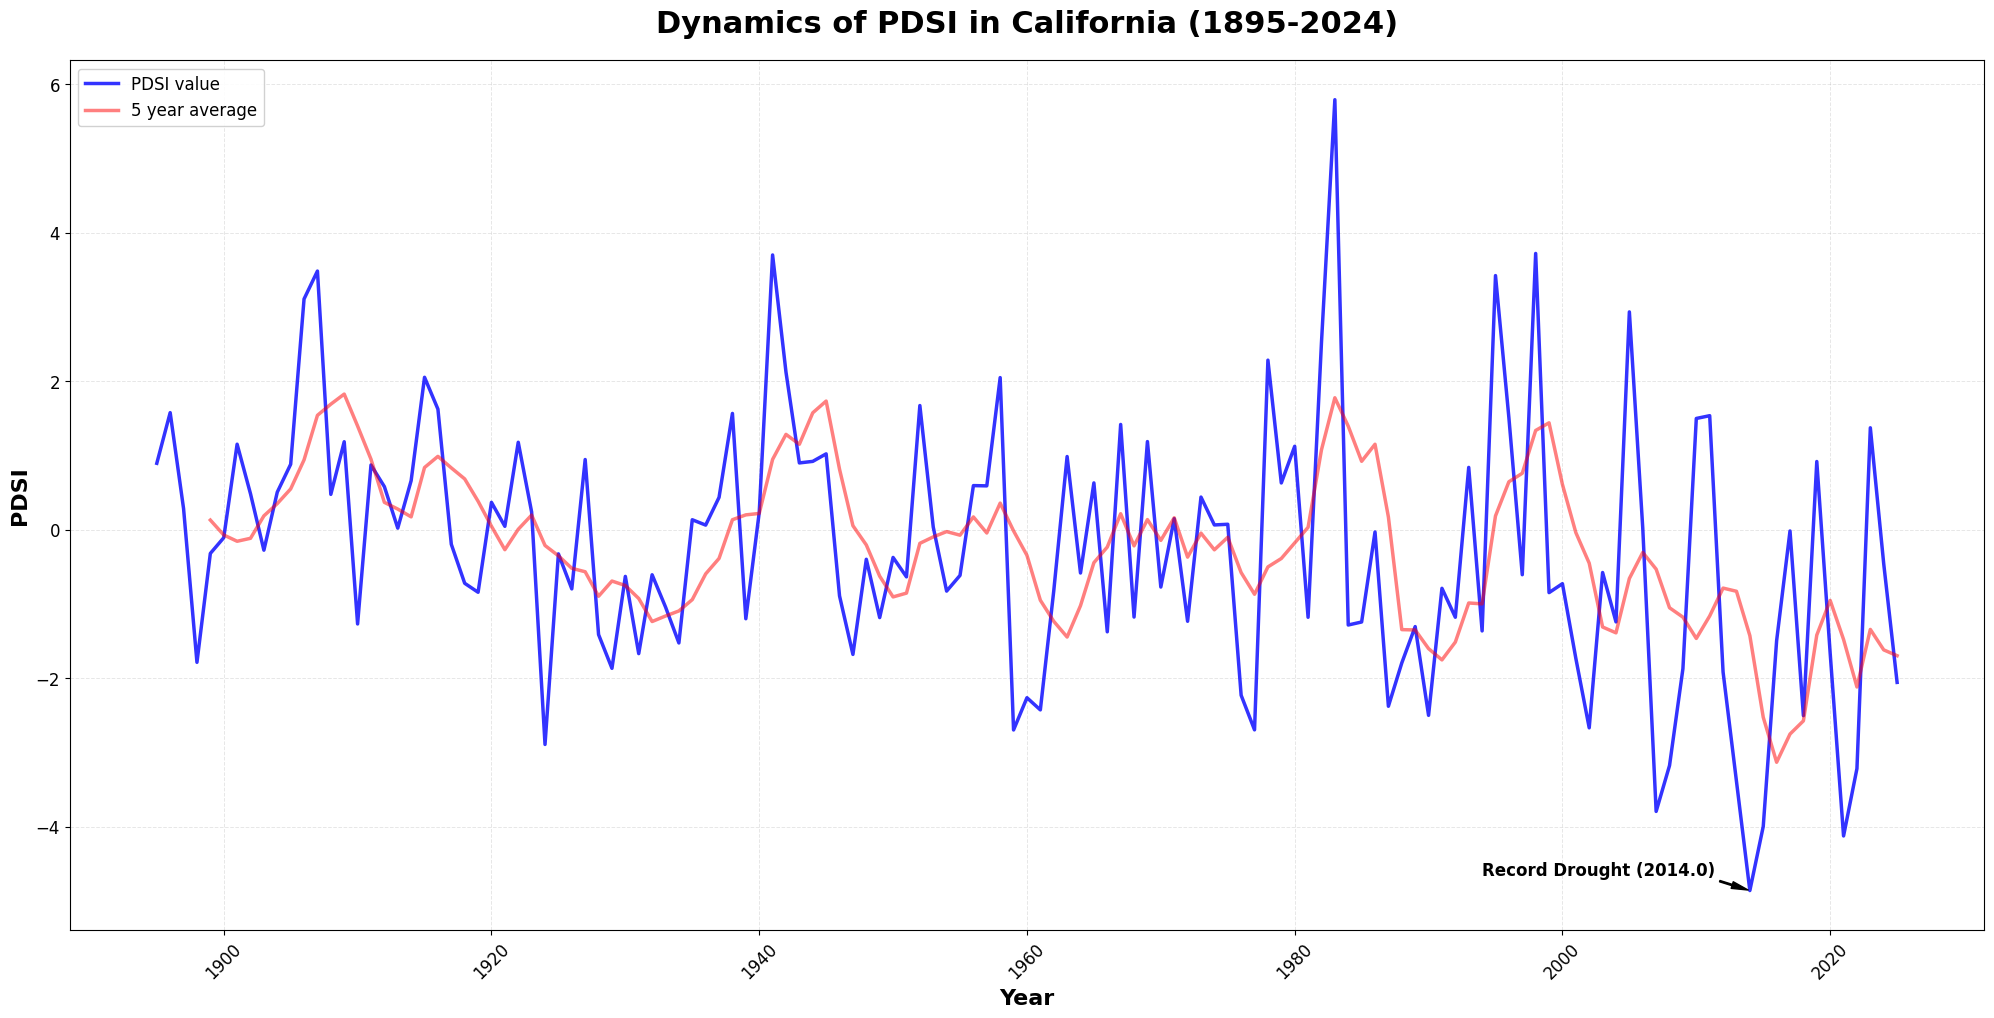

In [11]:
#Set the figure size
plt.figure(figsize=(20, 10))

#Visualize the original annual PDSI data (main dynamics)
line = sns.lineplot(data=avg_by_year, linewidth=2.5, color='blue', alpha=0.8, label="PDSI value")

#Overlay the moving average (trend) in red to see long-term climate changes by smoothing out annual fluctuations
sns.lineplot(y=rolling_avg, x=rolling_avg.index, color="red", linewidth=2.5, alpha=0.5, label="5 year average")

#Set the title
plt.title("Dynamics of PDSI in California (1895-2024)",
          fontsize=22, fontweight='bold', pad=20)

#Axis labels
plt.xlabel("Year", fontsize=16, fontweight='bold')
plt.ylabel("PDSI", fontsize=16, fontweight='bold')

#Legend settings
plt.legend(fontsize=12, loc='upper left', framealpha=0.9)

#Add a dotted grid
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

#Search and highlight historical minimum
min_year = avg_by_year.idxmin() # Determine the year with the lowest value
min_val = avg_by_year.min()     # Find the value of the extreme drought itself

# Add an annotation with an arrow pointing to the record drought
# xy — point on the graph, xytext — position of text relative to the point
plt.annotate(f'Record Drought ({min_year})',
             xy=(min_year, min_val),
             xytext=(min_year-20, min_val+0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=12, fontweight='bold')
# Automatically align graph elements
plt.tight_layout()

# Fine-tune fonts and axis tick rotation
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Display the final result
plt.show()

In [ ]:
#Check out the right side of the graph. Since the 2000s, the range and frequency of negative values (droughts) have gone up a lot compared to the early 20th century.

In [12]:
#Creating masks for filtering: first half(pre-1960) and second half(post 1960)
mask = df['Year'] <= 1960
masks = df['Year'] > 1960
#Creating copies for every DataFrame
df_1960 = df[mask].copy()
df_2025 = df[masks].copy()
#Select columns from Val_1 to Val_12, calculate the average, and convert the series into a DataFrame
avg_by_month_1960 = df_1960[[f'Val_{i}' for i in range(1, 13)]].mean().reset_index()
avg_by_month_1960.columns = ['month', 'avg'] #renaming columns for convenience
#Same operations for the other half
avg_by_month_2025 = df_2025[[f'Val_{i}' for i in range(1, 13)]].mean().reset_index()
avg_by_month_2025.columns = ['month', 'avg']

In [ ]:
## 3. Comparison of periods: 1895–1960 vs. 1961–2024
##To confirm the hypothesis of a systemic shift, we divided the data into two equal periods. This will allow us to see how the “average profile” of a year in California has changed.


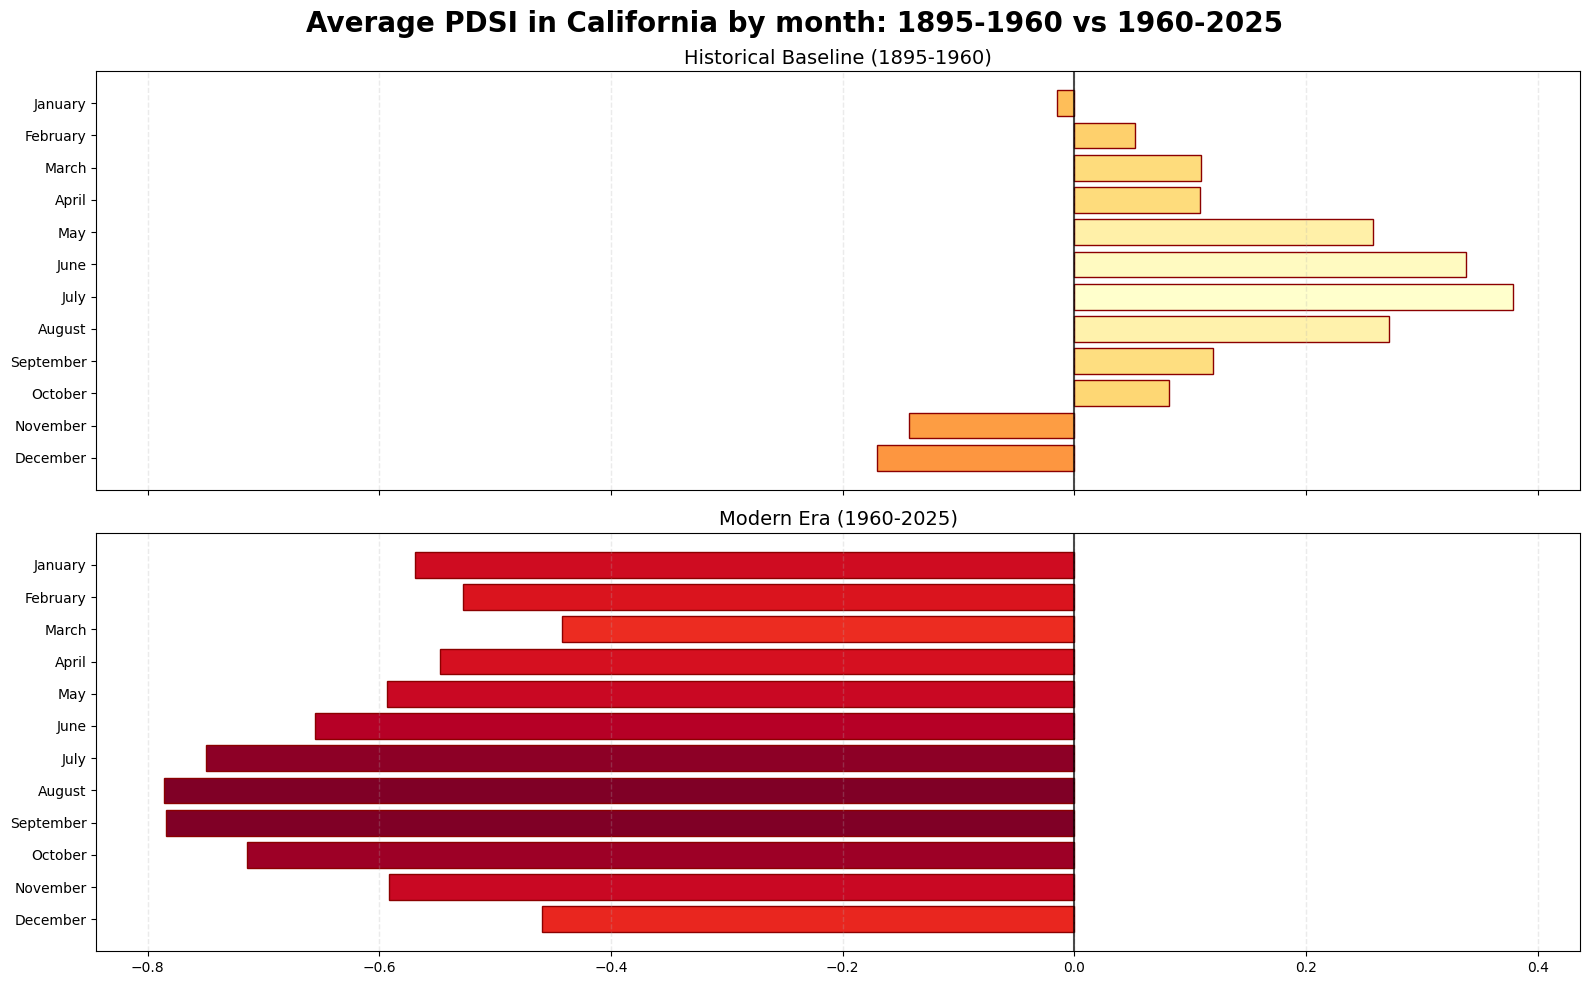

In [13]:
import matplotlib.colors as mcolors

# Define month labels for the Y-axis
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Calculate monthly averages for the historical period (1895-1960)
avg_by_month_1960 = df_1960[[f'Val_{i}' for i in range(1, 13)]].mean().reset_index()
avg_by_month_1960.columns = ['month', 'avg']

# Calculate monthly averages for the modern period (1961-2025)
avg_by_month_2025 = df_2025[[f'Val_{i}' for i in range(1, 13)]].mean().reset_index()
avg_by_month_2025.columns = ['month', 'avg']

# Initialize a figure with two vertical subplots sharing the same X and Y axes
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True, sharey=True)
fig.suptitle("Average PDSI in California by month: 1895-1960 vs 1960-2025", fontsize=20, fontweight='bold')

# Flatten axes array for easier indexing and assign to variables
axes = axes.flatten()
ax1, ax2 = axes[0], axes[1]

# Set up the color mapping: YlOrRd_r (Yellow-Orange-Red reversed)
# Values are normalized across both periods to ensure a consistent color scale
cmap = plt.cm.YlOrRd_r
norm = mcolors.Normalize(vmin=min(avg_by_month_2025['avg']), vmax=max(avg_by_month_1960['avg']))

# Configure titles for each subplot
ax1.set_title("Historical Baseline (1895-1960)", fontsize=14)
ax2.set_title("Modern Era (1960-2025)", fontsize=14)

# Create horizontal bar charts
# Colors are dynamically assigned based on the PDSI value (the drier, the redder)
ax1.barh(y=month_names, width=avg_by_month_1960['avg'],
         color=[cmap(norm(v)) for v in avg_by_month_1960['avg']], edgecolor='darkred')

ax2.barh(y=month_names, width=avg_by_month_2025['avg'],
         color=[cmap(norm(v)) for v in avg_by_month_2025['avg']], edgecolor='darkred')

# Add visual aids: dashed grid lines and a solid vertical line at the zero mark
for ax in [ax1, ax2]:
    ax.grid(axis='x', alpha=0.25, linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linewidth=1.5, alpha=0.7)

# Invert Y-axis so the year starts from January at the top
ax1.invert_yaxis()

# Adjust layout to prevent label overlapping
plt.tight_layout()
plt.show()

In [ ]:
## Phase 5: Statistical Summary and Final Assessment
##In this final step, we quantify the climatic shift by calculating the "Delta" between the two historical periods.
##By comparing the means, we can determine the exact magnitude of the aridification trend in California and identify which month has been most affected by increasing drought severity.

In [14]:
# --- STATISTICAL ANALYSIS: COMPARING EPOCHS ---

# Calculate the difference (delta) in PDSI values for each month between the two periods
delta = avg_by_month_2025['avg'] - avg_by_month_1960['avg']

# Compute the global average PDSI for the historical baseline (1895-1960)
total_avg_1960 = avg_by_month_1960['avg'].mean()

# Compute the global average PDSI for the modern era (1961-2024)
total_avg_2025 = avg_by_month_2025['avg'].mean()

# Calculate the overall climatic shift (negative value indicates a trend towards drought)
overall_drop = total_avg_2025 - total_avg_1960

# Identify the month with the most significant decrease in PDSI (the "worst hit" month)
max_drop_val = delta.min()
max_drop_month = month_names[delta.idxmin()]

# --- FINAL OUTPUT GENERATION ---

print(f"--- FINAL ASSESSMENT REPORT ---")
print(f"Historical Mean (1895-1960): {total_avg_1960:.3f}")
print(f"Modern Mean (1961-2024):     {total_avg_2025:.3f}")
print(f"Overall Shift:               {overall_drop:.3f} points")
print(f"Worst hit month:             {max_drop_month} (drop of {max_drop_val:.3f} points)")
print(f"-------------------------------")

--- FINAL ASSESSMENT REPORT ---
Historical Mean (1895-1960): 0.116
Modern Mean (1961-2024):     -0.619
Overall Shift:               -0.734 points
Worst hit month:             July (drop of -1.128 points)
-------------------------------
